In [3]:
import requests
import pandas as pd
import geopandas as gpd

from itertools import chain
from shapely.geometry import Point, MultiPoint
from feature_geometries import *
from itertools import chain
from bs4 import BeautifulSoup

import seaborn as sns

In [2]:
# Headers required for scraping the Zillow main results browser pafe
req_headers = {
    'accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8',
    'accept-encoding': 'gzip, deflate, br',
    'accept-language': 'en-US,en;q=0.8',
    'upgrade-insecure-requests': '1',
    'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/61.0.3163.100 Safari/537.36'
}

def url_rent(page):
    return 'https://www.zillow.com/homes/for_rent/Oakland-CA/all_type/13072_rid/37.971537,-121.981545,37.612327,-122.47593_rect/10_zm/' + page + '_p/'


In [4]:
# initialize lists for aggregating all Zillow rental data
all_addresses = []
all_characteristics = []
all_prices = []
all_lats = []
all_longs = []

#iterate through the first 40 pages of data (this should be all current listings in Oakland)
for page in np.arange(1, 40):
    with requests.Session() as s:
        url = url_rent(str(page))
        r = s.get(url, headers=req_headers)
        
        soup = BeautifulSoup(r.content, 'lxml')
        
        address = soup.find_all('span', {'itemprop': 'address'})
        characteristics = soup.find_all('span', {'class': 'zsg-photo-card-info'})
        price = soup.find_all('span', {'class': 'zsg-photo-card-price'})
        
        address_list = [value.text for value in address]
        char_list = [value.text for value in characteristics]
        price_list = [value.text for value in price]
        lat_list = [item['content'] for item in soup('meta') 
               if item.has_attr('itemprop') and item.attrs['itemprop']  == 'latitude']
        long_list = [item['content'] for item in soup('meta') 
               if item.has_attr('itemprop') and item.attrs['itemprop']  == 'longitude']
        
        # add to master list
        all_addresses.append(address_list)
        all_characteristics.append(char_list)
        all_prices.append(price_list)
        all_lats.append(lat_list)
        all_longs.append(long_list)



In [5]:
#clean the characteristics columns for erroneous price data
characteristics = list(chain.from_iterable(all_characteristics))
characteristics = [value for value in characteristics if not ('$' in value)]

# convert lists to a single pandas dataframe
All_rentals = pd.DataFrame(
    {'address': list(chain.from_iterable(all_addresses)),
     'latitude': list(chain.from_iterable(all_lats)),
     'longitude': list(chain.from_iterable(all_longs)),
     'price': list(chain.from_iterable(all_prices)),
     'characteristics': characteristics 
    })

All_rentals[['beds', 'baths', 'sqft']] = All_rentals['characteristics'].str.split('·\s+', expand=True)
All_rentals = All_rentals.drop('characteristics', axis=1)

#clean up the messy columns...
All_rentals['price'] = All_rentals.price.str.strip('$/mo')
All_rentals['price'] = All_rentals.price.str.replace(',', '')
All_rentals['price'] = All_rentals.price.str.replace('+', '').astype(int)

All_rentals['sqft'] = All_rentals.sqft.str.replace('sqft', '')
All_rentals['sqft'] = All_rentals.sqft.str.replace('--', '0')
All_rentals['sqft'] = All_rentals.sqft.str.replace(',', '').astype(int)
All_rentals['sqft'] = All_rentals.sqft.replace(0, np.nan)

All_rentals['latitude'] = All_rentals.latitude.astype(float)
All_rentals['longitude'] = All_rentals.longitude.astype(float)

# convert to geo dataframe
geometry = [Point(xy) for xy in zip(All_rentals.longitude, All_rentals.latitude)]
All_rentals = gpd.GeoDataFrame(All_rentals, geometry=geometry, crs={'init' :'epsg:4326'}) #Mercator lat long input

(703, 8)


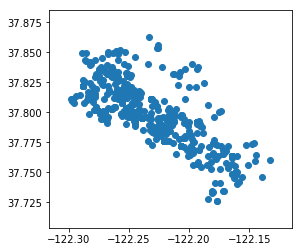

In [7]:
print(All_rentals.shape)
All_rentals.plot(); # plot the location of all rentals pulled from Zillow

In [11]:
#import neighborhood data
neighborhoods = gpd.read_file("./data/ZillowNeighborhoods-CA/ZillowNeighborhoods-CA.shp")
oakland_neighborhoods = neighborhoods[neighborhoods.City == "Oakland"]
oakland_neighborhoods.head()

,State,County,City,Name,RegionID,geometry
24,CA,Alameda,Oakland,Chinatown,114292,POLYGON ((-122.2700929749999 37.80135293100005...
273,CA,Alameda,Oakland,Adams Point,267990,POLYGON ((-122.2493849479999 37.81247701900008...
283,CA,Alameda,Oakland,Civic Center,268073,POLYGON ((-122.2629218196665 37.80108023766672...
291,CA,Alameda,Oakland,East Peralta,268125,POLYGON ((-122.2513529469999 37.79354501800009...
294,CA,Alameda,Oakland,Elmhurst Park,268142,POLYGON ((-122.1710949479999 37.74504101800005...


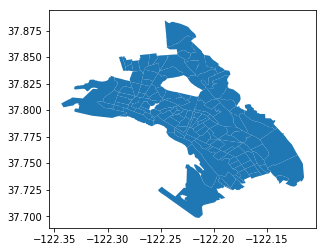

In [12]:
oakland_neighborhoods.plot() #plot neighborhood outlines

In [14]:
rentals_by_zone = gpd.sjoin(All_rentals, oakland_neighborhoods, how='left', op='intersects')

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [15]:
# Convert to dataframe of mean price and square-footage for rentals in all Oakland neighborhoods
neighborhoods = rentals_by_zone.groupby('Name').mean()
neighborhoods.drop(['index_right'], inplace = True, axis=1)
neighborhoods.reset_index(inplace = True)
neighborhoods.head()

,Name,latitude,longitude,price,sqft
0,Adams Point,37.812932,-122.255480,2811.933333,1190.875000
1,Allendale,37.790226,-122.202442,2800.000000,805.000000
2,Arroyo Viejo,37.761476,-122.178141,2411.250000,1021.666667
3,Bella Vista,37.800776,-122.237120,4950.000000,2400.000000
4,Brookfield Village,37.732368,-122.181632,1848.750000,911.666667


In [76]:
#import heatmap data to get average exposures by neighborhood
heatmap = import_gpd('./data/app/heatmap.csv')
pollution_by_zone = gpd.sjoin(heatmap, oakland_neighborhoods, how='inner', op='intersects')

/anaconda3/envs/OSMNX/lib/python3.6/site-packages/geopandas/tools/sjoin.py:44: UserWarning: CRS of frames being joined does not match!
  warn('CRS of frames being joined does not match!')


In [77]:
pollution = pollution_by_zone.groupby('Name')['no2', 'bc'].mean()
pollution.reset_index(inplace = True)
pollution.head()

,Name,no2,bc
0,Acorn,15.541501,0.516278
1,Acorn Industrial,22.539082,0.873373
2,Adams Point,13.443590,0.429612
3,Allendale,9.813637,0.321972
4,Arrowhead Marsh,13.532892,0.659737


In [78]:
all_data = neighborhoods.merge(pollution, on='Name')
all_data = oakland_neighborhoods.merge(all_data, on='Name')

In [80]:
all_data.head()

,State,County,City,Name,RegionID,geometry,latitude,longitude,price,sqft,no2,bc
0,CA,Alameda,Oakland,Chinatown,114292,POLYGON ((-122.2700929749999 37.80135293100005...,37.799394,-122.269657,2517.250000,811.666667,15.547257,0.527182
1,CA,Alameda,Oakland,Adams Point,267990,POLYGON ((-122.2493849479999 37.81247701900008...,37.812642,-122.254733,2915.235294,1237.909091,13.443590,0.429612
2,CA,Alameda,Oakland,Civic Center,268073,POLYGON ((-122.2629218196665 37.80108023766672...,37.799678,-122.265489,2095.000000,NaN,15.425390,0.546467
3,CA,Alameda,Oakland,East Peralta,268125,POLYGON ((-122.2513529469999 37.79354501800009...,37.792321,-122.254708,2200.000000,800.000000,15.462911,0.627419
4,CA,Alameda,Oakland,Fitchburg,268158,POLYGON ((-122.1825492669999 37.75486776300005...,37.755517,-122.187722,2500.000000,1216.000000,7.855514,0.336712


In [88]:
all_data.to_csv('neighborhood_summaries.csv')

In [82]:
def find_nearby_neighborhoods(location, neighborhoods, buffer_dist = 0.015):

    neighborhood_index = neighborhoods.sindex
    circle = location.buffer(buffer_dist) #build a km buffer around location
    
    possible_matches_index = list(neighborhood_index.intersection(circle.bounds)) #get index of possible neighborhoods
    possible_matches = neighborhoods.iloc[possible_matches_index]
    precise_matches = possible_matches[possible_matches.intersects(circle)].copy()

    return precise_matches


def get_healthy_suggestions(location, neighborhoods, price_range = 0.2, buffer_dist = 0.015):
    
    #find your current neighborhood...
    current_hood = neighborhoods[neighborhoods.intersects(location)]
    
    #find all neighborhoods within a mile (0.015 deg buffer)
    nearby_hoods = find_nearby_neighborhoods(location, neighborhoods)
    
    #subset neighborhoods in similar price bracket (default is +/- 20%)
    upper = 1 + price_range
    lower = 1 - price_range
    similar_hoods = nearby_hoods[nearby_hoods.price.between(current_hood['price'].iloc[0]*lower, 
                                                            current_hood['price'].iloc[0]*upper)]
    
    
    #find which neighborhoods have lower exposures 
    healthy_hoods = similar_hoods[similar_hoods.no2 < current_hood['no2'].iloc[0]]
    
    #how much lower are the exposure rates?
    healthy_hoods['percent_diff'] = (1 - (healthy_hoods['no2']/current_hood['no2'].iloc[0]))*100
    healthy_hoods['percent_diff'] = healthy_hoods['percent_diff'].astype(int)
    
    return healthy_hoods